# This Jupyter Notebook contains code that accompanies Allison Honold's Medium Blog Post
## Binning Records on a Continuous Variable with Pandas Cut and QCut: When, why, and how to transform a numeric feature into a categorical feature

In [28]:
# import necessary packages
import pandas as pd
from sodapy import Socrata
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [13]:
# import data

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.seattle.gov", None)
results = client.get("k9m8-nhz3", limit=1000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [14]:
# this data set is City of Seattle Wages: Comparison by Gender –Wage Progression Job Titles
# https://data.seattle.gov/City-Business/City-of-Seattle-Wages-Comparison-by-Gender-Wage-Pr/k9m8-nhz3

df.head()

,job_classification,female_avg_hrly_rate,no_female_empl,male_avg_hrly_rate,no_male_empl,total_avg_hrly_rate,total_no_empl,female_to_male_rate,female_to_male_count,notes
0,Accountant,30.58,23,30.28,7,30.51,30,101,329,NaN
1,"Accountant,Prin",38.75,23,37.64,7,38.49,30,103,329,NaN
2,"Accountant,Sr",34.479999999999997,23,33.89,6,34.36,29,102,383,NaN
3,Act Exec,43.1,4,42.02,7,42.42,11,103,57,NaN
4,Actg Tech I,22.56,1,NaN,NaN,22.56,1,NaN,NaN,no men in title


In [16]:
# fill NaN with 0
df = df.fillna(0)

# cast numeric strings as floats
cols = df.columns.drop(['job_classification', 'notes'])
df[cols] = df[cols].astype(float)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   job_classification    759 non-null    object 
 1   female_avg_hrly_rate  759 non-null    float64
 2   no_female_empl        759 non-null    float64
 3   male_avg_hrly_rate    759 non-null    float64
 4   no_male_empl          759 non-null    float64
 5   total_avg_hrly_rate   759 non-null    float64
 6   total_no_empl         759 non-null    float64
 7   female_to_male_rate   759 non-null    float64
 8   female_to_male_count  759 non-null    float64
 9   notes                 759 non-null    object 
dtypes: float64(8), object(2)
memory usage: 59.4+ KB


In [52]:
df.head(100)

,job_classification,female_avg_hrly_rate,no_female_empl,male_avg_hrly_rate,no_male_empl,total_avg_hrly_rate,total_no_empl,female_to_male_rate,female_to_male_count,notes,pay_class1,female_to_male_ratio,male_to_female_count
0,Accountant,30.58,23.0,30.28,7.0,30.51,30.0,101.0,329.0,0,"(25.36, 45.61]",3.285714,30.434783
1,"Accountant,Prin",38.75,23.0,37.64,7.0,38.49,30.0,103.0,329.0,0,"(25.36, 45.61]",3.285714,30.434783
2,"Accountant,Sr",34.48,23.0,33.89,6.0,34.36,29.0,102.0,383.0,0,"(25.36, 45.61]",3.833333,26.086957
3,Act Exec,43.10,4.0,42.02,7.0,42.42,11.0,103.0,57.0,0,"(25.36, 45.61]",0.571429,175.000000
4,Actg Tech I,22.56,1.0,0.00,0.0,22.56,1.0,0.0,0.0,no men in title,"(5.029, 25.36]",inf,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Cashier,Sr",19.38,3.0,18.74,1.0,19.22,4.0,103.0,300.0,0,"(5.029, 25.36]",3.000000,33.333333
96,Cblspl Aprn,0.00,0.0,31.68,4.0,31.68,4.0,0.0,0.0,no women in title,"(25.36, 45.61]",0.000000,NaN
97,Cblspl CC-Asg C Coord,0.00,0.0,46.28,2.0,46.28,2.0,0.0,0.0,no women in title,"(45.61, 65.86]",0.000000,NaN
98,Cblspl CC-Asg Locator,46.28,1.0,0.00,0.0,46.28,1.0,0.0,0.0,no men in title,"(45.61, 65.86]",inf,0.000000


# Ungrouped Data

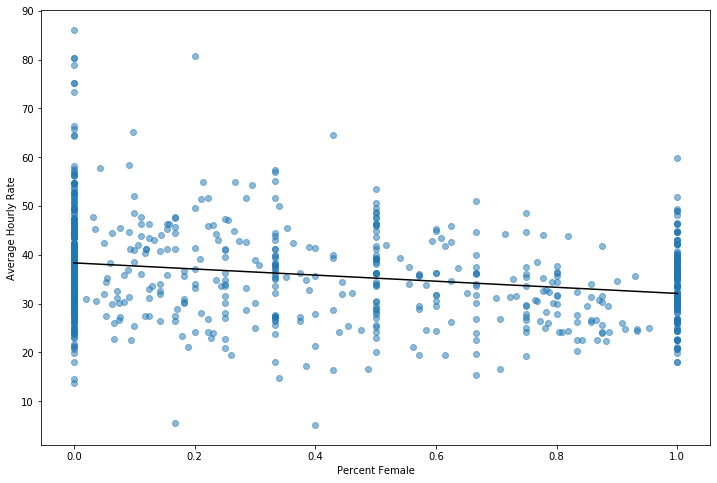

In [82]:
df['pct_female'] = df['no_female_empl'] / df['total_no_empl']
x = pct_female['pct_female']
y = pct_female['total_avg_hrly_rate']
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Percent Female')
plt.ylabel('Average Hourly Rate')
plt.scatter(x, y, alpha=.5)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black');

In [78]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

In [79]:
rvalue*rvalue

0.05626259742864945

In [80]:
stats.linregress(x, y)

LinregressResult(slope=-6.2579420852675245, intercept=38.329735198606116, rvalue=-0.23719738073732907, pvalue=3.6239874781585875e-11, stderr=0.9315352522301691)

# Grouping job titles by total average hourly rate

In [88]:
pct_female['pct_fml_grp'] = pd.cut(pct_female['pct_female'], 5)

In [89]:
pct_female.loc[:, 'total_avg_hrly_rate':].head()

,total_avg_hrly_rate,pct_female,pay_class1,pct_fml_grp
0,30.51,0.766667,"(21.31, 37.51]","(0.6, 0.8]"
1,38.49,0.766667,"(37.51, 53.71]","(0.6, 0.8]"
2,34.36,0.793103,"(21.31, 37.51]","(0.6, 0.8]"
3,42.42,0.363636,"(37.51, 53.71]","(0.2, 0.4]"
4,22.56,1.000000,"(21.31, 37.51]","(0.8, 1.0]"


In [ ]:
pct_female.groupby('pct_fml_grp', how='')

In [ ]:
x = pct_female['pct_fml_grp']
y = pct_female['total_avg_hrly_rate']
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Percent Female')
plt.ylabel('Average Hourly Rate')
plt.scatter(x, y, alpha=.5)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black');